In [1]:
import glob
import json
import os
import re
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%cd /home/nassimb/workspace/uparis/m2/pfe/text-role-classification

/home/nassimb/workspace/uparis/m2/pfe/text-role-classification


# Training dataset

In [3]:
train_annot_folder_path = (
    "./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/annotations_JSON"
)

# Recursively find all .json files
train_annot_paths = glob.glob(
    os.path.join(train_annot_folder_path, "**", "*.json"), recursive=True
)

len(train_annot_paths)

22923

In [4]:
train_annot_paths[0]

'./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/annotations_JSON/map/PMC5664696___ijerph-14-01195-g002.json'

In [5]:
train_img_folder_path = "./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images"

# Recursively find all .json files
train_img_paths = glob.glob(
    os.path.join(train_img_folder_path, "**", "*.jpg"), recursive=True
)

len(train_img_paths)

22923

In [6]:
icpr2022_train = {
    "text": [],
    "role": [],
    "x0": [],
    "x1": [],
    "x2": [],
    "x3": [],
    "y0": [],
    "y1": [],
    "y2": [],
    "y3": [],
    "chart_type": [],
    "annot_file": [],
    "img": [],
}

try:
    for file_path in train_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    icpr2022_train["text"].append(text_block["text"])
                    icpr2022_train["role"].append(
                        data["task3"]["output"]["text_roles"][i]["role"]
                    )
                    icpr2022_train["x0"].append(text_block["polygon"]["x0"])
                    icpr2022_train["x1"].append(text_block["polygon"]["x1"])
                    icpr2022_train["x2"].append(text_block["polygon"]["x2"])
                    icpr2022_train["x3"].append(text_block["polygon"]["x3"])
                    icpr2022_train["y0"].append(text_block["polygon"]["y0"])
                    icpr2022_train["y1"].append(text_block["polygon"]["y1"])
                    icpr2022_train["y2"].append(text_block["polygon"]["y2"])
                    icpr2022_train["y3"].append(text_block["polygon"]["y3"])
                    icpr2022_train["chart_type"].append(
                        data["task3"]["input"]["task1_output"]["chart_type"]
                    )
                    icpr2022_train["annot_file"].append(file_path)
                    pos_img = file_path.replace("annotations_JSON", "images").replace(
                        "json", "jpg"
                    )
                    if os.path.exists(pos_img):
                        icpr2022_train["img"].append(pos_img)
                    else:
                        icpr2022_train["img"].append(None)
                    i += 1

            else:
                icpr2022_train["text"].append(None)
                icpr2022_train["role"].append(None)
                icpr2022_train["x0"].append(None)
                icpr2022_train["x1"].append(None)
                icpr2022_train["x2"].append(None)
                icpr2022_train["x3"].append(None)
                icpr2022_train["y0"].append(None)
                icpr2022_train["y1"].append(None)
                icpr2022_train["y2"].append(None)
                icpr2022_train["y3"].append(None)
                icpr2022_train["chart_type"].append(None)
                icpr2022_train["annot_file"].append(file_path)
                pos_img = file_path.replace("annotations_JSON", "images").replace(
                    "json", "jpg"
                )
                if os.path.exists(pos_img):
                    icpr2022_train["img"].append(pos_img)
                else:
                    icpr2022_train["img"].append(None)

except Exception as e:
    print(e, file_path)

In [7]:
df_icpr2022_train = pd.DataFrame(icpr2022_train)
df_icpr2022_train.head()

,text,role,x0,x1,x2,x3,y0,y1,y2,y3,chart_type,annot_file,img
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
4,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....


In [8]:
df_icpr2022_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152239 entries, 0 to 152238
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   text        135786 non-null  object 
 1   role        135786 non-null  object 
 2   x0          135786 non-null  float64
 3   x1          135786 non-null  float64
 4   x2          135786 non-null  float64
 5   x3          135786 non-null  float64
 6   y0          135786 non-null  float64
 7   y1          135786 non-null  float64
 8   y2          135786 non-null  float64
 9   y3          135786 non-null  float64
 10  chart_type  135786 non-null  object 
 11  annot_file  152239 non-null  object 
 12  img         152239 non-null  object 
dtypes: float64(8), object(5)
memory usage: 15.1+ MB


In [9]:
df_icpr2022_train.describe()

,x0,x1,x2,x3,y0,y1,y2,y3
count,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000
mean,230.602875,275.297674,275.554225,230.864588,266.750983,265.648624,289.687987,290.785015
std,210.314113,220.154078,220.254210,210.408102,170.030602,169.318724,168.837033,169.477240
min,-4.000000,6.000000,6.000000,-3.000000,-8.000000,-5.000000,2.000000,6.000000
25%,46.000000,76.000000,76.000000,46.000000,127.000000,127.000000,157.000000,157.000000
50%,164.000000,220.000000,221.000000,165.000000,260.000000,259.000000,286.000000,288.000000
75%,387.000000,447.000000,448.000000,387.000000,389.000000,387.000000,408.000000,409.000000
max,2737.000000,2870.000000,2870.000000,2737.000000,2138.000000,2138.000000,2223.000000,2223.000000


In [10]:
df_icpr2022_train.isnull().sum()

text          16453
role          16453
x0            16453
x1            16453
x2            16453
x3            16453
y0            16453
y1            16453
y2            16453
y3            16453
chart_type    16453
annot_file        0
img               0
dtype: int64

In [11]:
df_icpr2022_train["role"].value_counts()

role
tick_label       95430
legend_label     12286
axis_title       10721
value_label       7649
other             6305
mark_label        1920
tick_grouping      792
chart_title        493
legend_title       190
Name: count, dtype: int64

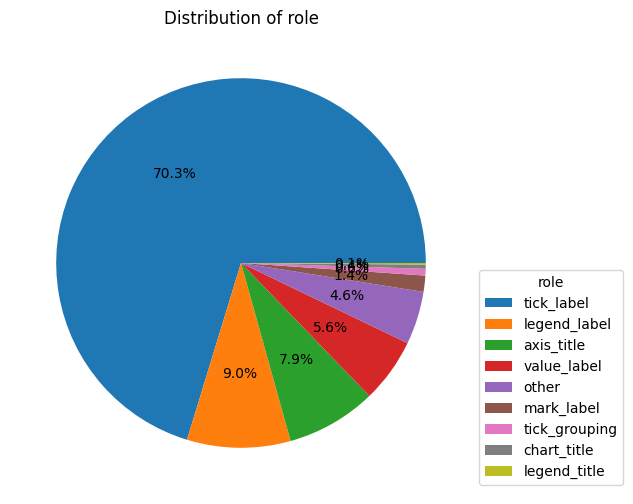

In [12]:
counts = df_icpr2022_train["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [13]:
df_icpr2022_train["chart_type"].value_counts()

chart_type
line                   46798
vertical bar           40130
horizontal bar         19183
scatter                19134
vertical box            9194
scatter-line            1287
vertical interval         46
horizontal interval       14
Name: count, dtype: int64

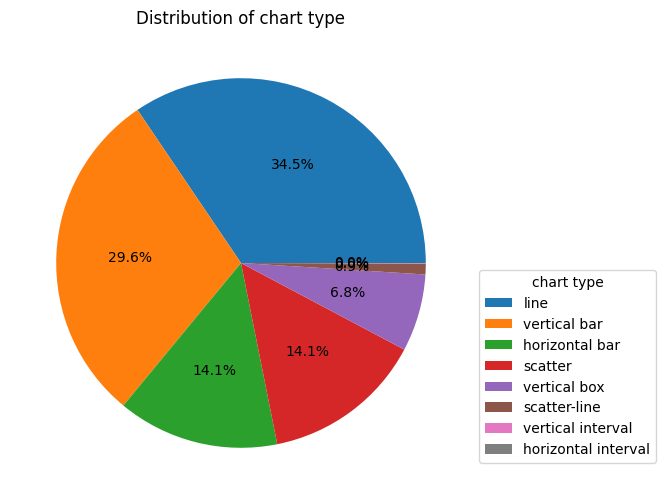

In [14]:
counts = df_icpr2022_train["chart_type"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [15]:
df_icpr2022_train.nunique()

text          42048
role              9
x0              853
x1              867
x2              868
x3              852
y0              992
y1              985
y2             1012
y3             1015
chart_type        8
annot_file    22923
img           22923
dtype: int64

In [16]:
df_icpr2022_train[df_icpr2022_train["role"].notnull()].nunique()

text          42048
role              9
x0              853
x1              867
x2              868
x3              852
y0              992
y1              985
y2             1012
y3             1015
chart_type        8
annot_file     6470
img            6470
dtype: int64

In [17]:
df_icpr2022_train[df_icpr2022_train["role"].notnull()].head()

,text,role,x0,x1,x2,x3,y0,y1,y2,y3,chart_type,annot_file,img
534,Group,axis_title,372.0,432.0,432.0,372.0,430.0,430.0,453.0,453.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
535,BCP/Hyaluronic,tick_label,578.0,702.0,702.0,578.0,401.0,401.0,422.0,422.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
536,BCP/CMC-crosslink,tick_label,407.0,563.0,563.0,407.0,401.0,401.0,418.0,418.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
537,BCP/CMC,tick_label,291.0,372.0,372.0,291.0,401.0,401.0,418.0,418.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
538,BCP(control),tick_label,127.0,227.0,227.0,127.0,399.0,399.0,422.0,422.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....


In [18]:
random_img_path = (
    df_icpr2022_train[
        df_icpr2022_train["role"].notnull()
        & (df_icpr2022_train["chart_type"] == "horizontal interval")
    ]["img"]
    .sample(1)
    .values[0]
)
# random_img_path = "./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images/line/PMC5615651___materials-10-00996-g007.jpg"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_icpr2022_train[
    df_icpr2022_train["img"] == random_img_path
].iterrows():
    labeled_polygons.append(
        (
            [
                (row["x0"], row["y0"]),
                (row["x1"], row["y1"]),
                (row["x2"], row["y2"]),
                (row["x3"], row["y3"]),
            ],
            row["role"],
        )
    )

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    pts_arr = np.array(points, np.int32).reshape((-1, 1, 2))
    cv2.polylines(img, [pts_arr], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (int(points[0][0]), int(points[0][1]) - 5),
        font,
        scale,
        color,
        thikness,
    )

cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images/horizontal_interval/PMC5455512___materials-08-05138-g007.jpg


True

In [19]:
!pwd

/home/nassimb/workspace/uparis/m2/pfe/text-role-classification


In [20]:
train_out_dir = "./datasets/_ICPR2022Real/train"
os.makedirs(f"{train_out_dir}/annotations", exist_ok=True)
os.makedirs(f"{train_out_dir}/images", exist_ok=True)

In [21]:
try:
    for file_path in train_annot_paths:
        file_name = os.path.basename(file_path)
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    text_block["polygon"]["x0"] = max(0, text_block["polygon"]["x0"])
                    text_block["polygon"]["x1"] = max(0, text_block["polygon"]["x1"])
                    text_block["polygon"]["x2"] = max(0, text_block["polygon"]["x2"])
                    text_block["polygon"]["x3"] = max(0, text_block["polygon"]["x3"])
                    text_block["polygon"]["y0"] = max(0, text_block["polygon"]["y0"])
                    text_block["polygon"]["y1"] = max(0, text_block["polygon"]["y1"])
                    text_block["polygon"]["y2"] = max(0, text_block["polygon"]["y2"])
                    text_block["polygon"]["y3"] = max(0, text_block["polygon"]["y3"])
                with open(f"{train_out_dir}/annotations/{file_name}", "w") as f:
                    json.dump(data, f)
                    img = file_path.replace("annotations_JSON", "images").replace(
                        "json", "jpg"
                    )
                    shutil.copy(
                        img,
                        f"{train_out_dir}/images/{file_name.replace('json', 'jpg')}",
                    )

except Exception as e:
    print(e, file_path)

# Test dataset

## ICPR2022

In [22]:
icpr2022_test_annot_folder_path = (
    "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/final_full_GT"
)

# Recursively find all .json files
icpr2022_test_annot_paths = glob.glob(
    os.path.join(icpr2022_test_annot_folder_path, "**", "annotations_JSON", "*.json"),
    recursive=True,
)

len(icpr2022_test_annot_paths)

13259

In [23]:
icpr2022_test_annot_paths[0]

'./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/final_full_GT/split_1/annotations_JSON/PMC6428810___1_HTML.json'

In [24]:
icpr2022_test_img_folder_path = (
    "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images"
)

# Recursively find all .json files
icpr2022_test_img_paths = glob.glob(
    os.path.join(icpr2022_test_img_folder_path, "**", "images", "*.jpg"), recursive=True
)

len(icpr2022_test_img_paths)

13259

In [25]:
icpr2022_test = {
    "text": [],
    "role": [],
    "x0": [],
    "x1": [],
    "x2": [],
    "x3": [],
    "y0": [],
    "y1": [],
    "y2": [],
    "y3": [],
    "chart_type": [],
    "annot_file": [],
    "img": [],
}

try:
    for file_path in icpr2022_test_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    icpr2022_test["text"].append(text_block["text"])
                    icpr2022_test["role"].append(
                        data["task3"]["output"]["text_roles"][i]["role"]
                    )
                    icpr2022_test["x0"].append(text_block["polygon"]["x0"])
                    icpr2022_test["x1"].append(text_block["polygon"]["x1"])
                    icpr2022_test["x2"].append(text_block["polygon"]["x2"])
                    icpr2022_test["x3"].append(text_block["polygon"]["x3"])
                    icpr2022_test["y0"].append(text_block["polygon"]["y0"])
                    icpr2022_test["y1"].append(text_block["polygon"]["y1"])
                    icpr2022_test["y2"].append(text_block["polygon"]["y2"])
                    icpr2022_test["y3"].append(text_block["polygon"]["y3"])
                    icpr2022_test["chart_type"].append(
                        data["task3"]["input"]["task1_output"]["chart_type"]
                    )
                    icpr2022_test["annot_file"].append(file_path)
                    pos_img = (
                        file_path.replace("final_full_GT", "chart_images")
                        .replace("annotations_JSON", "images")
                        .replace("json", "jpg")
                    )
                    if os.path.exists(pos_img):
                        icpr2022_test["img"].append(pos_img)
                    else:
                        icpr2022_test["img"].append(None)
                    i += 1

            else:
                icpr2022_test["text"].append(None)
                icpr2022_test["role"].append(None)
                icpr2022_test["x0"].append(None)
                icpr2022_test["x1"].append(None)
                icpr2022_test["x2"].append(None)
                icpr2022_test["x3"].append(None)
                icpr2022_test["y0"].append(None)
                icpr2022_test["y1"].append(None)
                icpr2022_test["y2"].append(None)
                icpr2022_test["y3"].append(None)
                icpr2022_test["chart_type"].append(None)
                icpr2022_test["annot_file"].append(file_path)
                pos_img = (
                    file_path.replace("final_full_GT", "chart_images")
                    .replace("annotations_JSON", "images")
                    .replace("json", "jpg")
                )
                if os.path.exists(pos_img):
                    icpr2022_test["img"].append(pos_img)
                else:
                    icpr2022_test["img"].append(None)

except Exception as e:
    print(e, file_path)

In [26]:
df_icpr2022_test = pd.DataFrame(icpr2022_test)
df_icpr2022_test.head()

,text,role,x0,x1,x2,x3,y0,y1,y2,y3,chart_type,annot_file,img
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
4,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...


In [27]:
df_icpr2022_test["split"] = df_icpr2022_test["annot_file"].str.extract(r"/(split_\d+)/")

In [28]:
df_icpr2022_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52040 entries, 0 to 52039
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        40654 non-null  object 
 1   role        40654 non-null  object 
 2   x0          40654 non-null  float64
 3   x1          40654 non-null  float64
 4   x2          40654 non-null  float64
 5   x3          40654 non-null  float64
 6   y0          40654 non-null  float64
 7   y1          40654 non-null  float64
 8   y2          40654 non-null  float64
 9   y3          40654 non-null  float64
 10  chart_type  40654 non-null  object 
 11  annot_file  52040 non-null  object 
 12  img         52040 non-null  object 
 13  split       52040 non-null  object 
dtypes: float64(8), object(6)
memory usage: 5.6+ MB


In [29]:
df_icpr2022_test.describe()

,x0,x1,x2,x3,y0,y1,y2,y3
count,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000
mean,241.306440,287.360875,287.770035,241.716338,281.210090,279.153097,302.914695,304.968343
std,217.287315,226.768200,226.935584,217.434362,179.728169,178.180529,177.315521,178.740717
min,-5.000000,7.000000,7.000000,-2.000000,-1.000000,-5.000000,6.000000,6.000000
25%,44.000000,74.000000,74.000000,44.000000,131.000000,131.000000,161.000000,161.000000
50%,178.000000,242.000000,243.000000,179.000000,278.000000,276.000000,302.000000,304.000000
75%,408.000000,466.000000,466.000000,408.000000,414.000000,409.000000,430.000000,434.000000
max,2090.000000,2186.000000,2186.000000,2090.000000,1521.000000,1521.000000,1540.000000,1540.000000


In [30]:
df_icpr2022_test.isnull().sum()

text          11386
role          11386
x0            11386
x1            11386
x2            11386
x3            11386
y0            11386
y1            11386
y2            11386
y3            11386
chart_type    11386
annot_file        0
img               0
split             0
dtype: int64

In [31]:
df_icpr2022_test["role"].value_counts()

role
tick_label       28032
legend_label      3888
axis_title        3022
other             2741
value_label       1575
mark_label         764
tick_grouping      290
chart_title        226
legend_title       116
Name: count, dtype: int64

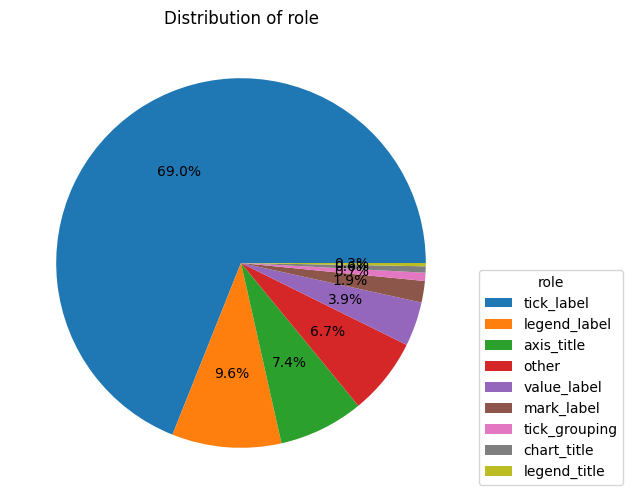

In [32]:
counts = df_icpr2022_test["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [33]:
df_icpr2022_test["chart_type"].value_counts()

chart_type
line              13088
vertical bar      12458
scatter            6477
horizontal bar     5518
vertical box       3065
scatter-line         48
Name: count, dtype: int64

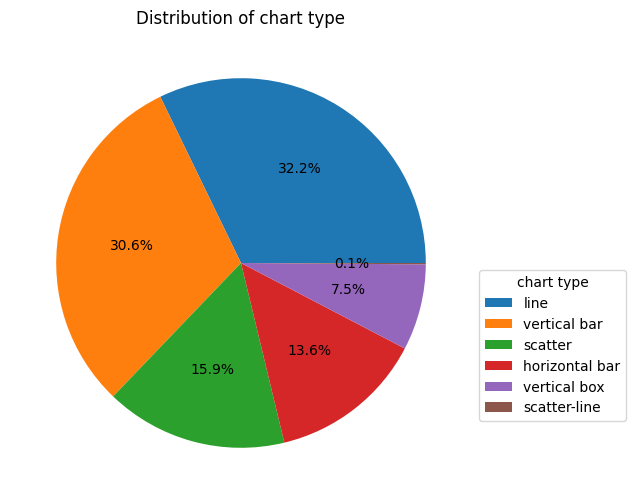

In [34]:
counts = df_icpr2022_test["chart_type"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [35]:
df_icpr2022_test["split"].value_counts()

split
split_2    13243
split_1    11434
split_4     9969
split_5     9235
split_3     8159
Name: count, dtype: int64

In [36]:
df_icpr2022_test[df_icpr2022_test["role"].notnull()]["split"].value_counts()

split
split_2    13243
split_4     9969
split_5     9235
split_3     8159
split_1       48
Name: count, dtype: int64

In [37]:
df_icpr2022_test.nunique()

text          15314
role              9
x0              822
x1              844
x2              841
x3              821
y0              868
y1              858
y2              888
y3              901
chart_type        6
annot_file    13259
img           13259
split             5
dtype: int64

In [38]:
df_icpr2022_test[df_icpr2022_test["role"].notnull()].nunique()

text          15314
role              9
x0              822
x1              844
x2              841
x3              821
y0              868
y1              858
y2              888
y3              901
chart_type        6
annot_file     1873
img            1873
split             5
dtype: int64

In [39]:
random_img_path = (
    df_icpr2022_test[df_icpr2022_test["role"].notnull()]["img"].sample(1).values[0]
)
# random_img_path = "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/split_2/images/PMC6404038___2.jpg"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_icpr2022_test[df_icpr2022_test["img"] == random_img_path].iterrows():
    labeled_polygons.append(
        (
            [
                (row["x0"], row["y0"]),
                (row["x1"], row["y1"]),
                (row["x2"], row["y2"]),
                (row["x3"], row["y3"]),
            ],
            row["role"],
        )
    )

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    pts_arr = np.array(points, np.int32).reshape((-1, 1, 2))
    cv2.polylines(img, [pts_arr], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (int(points[0][0]), int(points[0][1]) - 5),
        font,
        scale,
        color,
        thikness,
    )

cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/split_4/images/PMC2864749___g004.jpg


True

In [40]:
test_out_dir = "./datasets/_ICPR2022Real/test"
os.makedirs(f"{test_out_dir}/annotations", exist_ok=True)
os.makedirs(f"{test_out_dir}/images", exist_ok=True)

In [41]:
try:
    for file_path in icpr2022_test_annot_paths:
        file_name = os.path.basename(file_path)
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    text_block["polygon"]["x0"] = max(0, text_block["polygon"]["x0"])
                    text_block["polygon"]["x1"] = max(0, text_block["polygon"]["x1"])
                    text_block["polygon"]["x2"] = max(0, text_block["polygon"]["x2"])
                    text_block["polygon"]["x3"] = max(0, text_block["polygon"]["x3"])
                    text_block["polygon"]["y0"] = max(0, text_block["polygon"]["y0"])
                    text_block["polygon"]["y1"] = max(0, text_block["polygon"]["y1"])
                    text_block["polygon"]["y2"] = max(0, text_block["polygon"]["y2"])
                    text_block["polygon"]["y3"] = max(0, text_block["polygon"]["y3"])
                with open(f"{test_out_dir}/annotations/{file_name}", "w") as f:
                    json.dump(data, f)
                    img = (
                        file_path.replace("final_full_GT", "chart_images")
                        .replace("annotations_JSON", "images")
                        .replace("json", "jpg")
                    )

                    shutil.copy(
                        img,
                        f"{test_out_dir}/images/{file_name.replace('json', 'jpg')}",
                    )

except Exception as e:
    print(e, file_path)

## EconBiz

In [42]:
econbiz_annot_folder_path = "./datasets/EconBiz"

# Recursively find all .json files
econbiz_annot_paths = glob.glob(
    os.path.join(econbiz_annot_folder_path, "**", "annotations", "*.json"),
    recursive=True,
)

len(econbiz_annot_paths)

121

In [43]:
econbiz_annot_paths[0]

'./datasets/EconBiz/train/annotations/10008831881-008.json'

In [44]:
econbiz_img_folder_path = "./datasets/EconBiz"

# Recursively find all .json files
econbiz_img_paths = glob.glob(
    os.path.join(econbiz_img_folder_path, "**", "images", "*.png"), recursive=True
)

len(econbiz_img_paths)

121

In [45]:
econbiz = {
    "text": [],
    "role": [],
    "center_x": [],
    "center_y": [],
    "width": [],
    "height": [],
    "orientation": [],
    "annot_file": [],
    "img": [],
}

try:
    for file_path in econbiz_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            for text_element in data["textelements"]:
                econbiz["text"].append(text_element["content"])
                econbiz["role"].append(text_element["role"])
                econbiz["center_x"].append(text_element["boundingbox"]["center_x"])
                econbiz["center_y"].append(text_element["boundingbox"]["center_y"])
                econbiz["width"].append(text_element["boundingbox"]["width"])
                econbiz["height"].append(text_element["boundingbox"]["height"])
                econbiz["orientation"].append(
                    text_element["boundingbox"]["orientation"]
                )
                econbiz["annot_file"].append(file_path)
                econbiz["img"].append(
                    file_path.replace("annotations", "images").replace("json", "png")
                )

except Exception as e:
    print(e, file_path)

In [46]:
df_econbiz = pd.DataFrame(econbiz)
df_econbiz.head()

,text,role,center_x,center_y,width,height,orientation,annot_file,img
0,ψ,other,237,98,28,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...
1,ψ,other,426,499,28,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...
2,5' LTR,other,119,113,90,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...
3,5' LTR,other,357,516,90,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...
4,ORF,other,673,516,62,29,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...


In [47]:
df_econbiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         3057 non-null   object
 1   role         3057 non-null   object
 2   center_x     3057 non-null   int64 
 3   center_y     3057 non-null   int64 
 4   width        3057 non-null   int64 
 5   height       3057 non-null   int64 
 6   orientation  3057 non-null   int64 
 7   annot_file   3057 non-null   object
 8   img          3057 non-null   object
dtypes: int64(5), object(4)
memory usage: 215.1+ KB


In [48]:
df_econbiz.describe()

,center_x,center_y,width,height,orientation
count,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000
mean,413.217206,408.154727,69.338240,22.710173,-12.906444
std,326.420953,215.973175,85.088652,6.692361,34.421411
min,12.000000,9.000000,10.000000,10.000000,-270.000000
25%,116.000000,237.000000,27.000000,18.000000,0.000000
50%,362.000000,427.000000,43.000000,21.000000,0.000000
75%,627.000000,556.000000,78.000000,26.000000,0.000000
max,1849.000000,1122.000000,1046.000000,54.000000,270.000000


In [49]:
df_econbiz.isnull().sum()

text           0
role           0
center_x       0
center_y       0
width          0
height         0
orientation    0
annot_file     0
img            0
dtype: int64

In [50]:
df_econbiz["role"].value_counts()

role
tick_label       1805
other             440
legend_label      258
value_label       175
mark_label        175
axis_title        125
chart_title        36
tick_grouping      36
legend_title        7
Name: count, dtype: int64

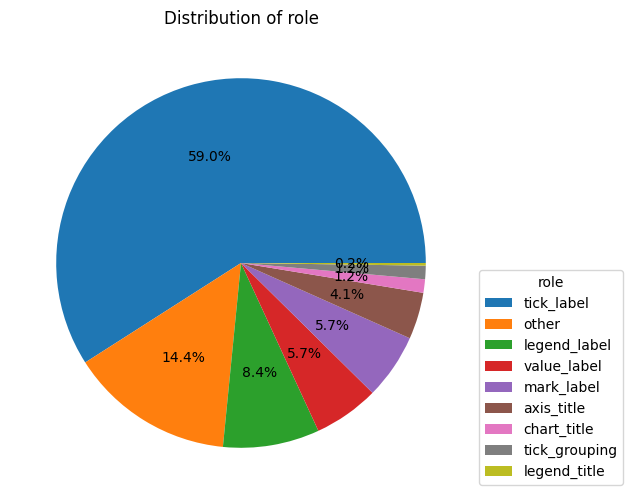

In [51]:
counts = df_econbiz["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [52]:
df_econbiz.nunique()

text           1780
role              9
center_x        971
center_y        783
width           300
height           42
orientation      18
annot_file      121
img             121
dtype: int64

In [53]:
df_econbiz[df_econbiz["role"].notnull()].nunique()

text           1780
role              9
center_x        971
center_y        783
width           300
height           42
orientation      18
annot_file      121
img             121
dtype: int64

In [77]:
random_img_path = df_econbiz[df_econbiz["role"].notnull()]["img"].sample(1).values[0]
# random_img_path = "./datasets/EconBiz/train/images/10009328051-017.png"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_econbiz[df_econbiz["img"] == random_img_path].iterrows():
    rect = (
        (row["center_x"], row["center_y"]),
        (row["width"], row["height"]),
        row["orientation"],
    )
    points = cv2.boxPoints(rect)  # returns float32
    labeled_polygons.append((points.astype(int), row["role"]))

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    cv2.polylines(img, [points], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (points[0, 0], points[0, 1] + 15),
        font,
        scale,
        color,
        thikness,
    )
cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/EconBiz/train/images/10009328051-017.png


True

## CHIMIE-R

In [55]:
chimie_r_annot_folder_path = "./datasets/CHIME-R"

# Recursively find all .json files
chimie_r_annot_paths = glob.glob(
    os.path.join(chimie_r_annot_folder_path, "**", "annotations", "*.json"),
    recursive=True,
)

len(chimie_r_annot_paths)

115

In [56]:
chimie_r_annot_paths[0]

'./datasets/CHIME-R/train/annotations/dbar011.json'

In [57]:
chimie_r_img_folder_path = "./datasets/CHIME-R"

# Recursively find all .json files
chimie_r_img_paths = glob.glob(
    os.path.join(chimie_r_img_folder_path, "**", "images", "*.bmp"), recursive=True
)

len(chimie_r_img_paths)

115

In [58]:
chimie_r = {
    "text": [],
    "role": [],
    "center_x": [],
    "center_y": [],
    "width": [],
    "height": [],
    "orientation": [],
    "annot_file": [],
    "img": [],
    "chart_type": [],
}

try:
    for file_path in chimie_r_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            for text_element in data["textelements"]:
                chimie_r["text"].append(text_element["content"])
                chimie_r["role"].append(text_element["role"])
                chimie_r["center_x"].append(text_element["boundingbox"]["center_x"])
                chimie_r["center_y"].append(text_element["boundingbox"]["center_y"])
                chimie_r["width"].append(text_element["boundingbox"]["width"])
                chimie_r["height"].append(text_element["boundingbox"]["height"])
                chimie_r["orientation"].append(
                    text_element["boundingbox"]["orientation"]
                )
                chimie_r["annot_file"].append(file_path)
                chimie_r["img"].append(
                    file_path.replace("annotations", "images").replace("json", "bmp")
                )
                file_name = os.path.basename(file_path)
                chimie_r["chart_type"].append(re.match(r"^\D*", file_name).group())

except Exception as e:
    print(e, file_path)

In [59]:
df_chimie_r = pd.DataFrame(chimie_r)
df_chimie_r.head()

,text,role,center_x,center_y,width,height,orientation,annot_file,img,chart_type
0,Governors Challenge Goal 2,chart_title,331,32,282,19,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar
1,"16,000,000",tick_label,88,121,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar
2,"14,000,000",tick_label,88,148,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar
3,"12,000,000",tick_label,88,175,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar
4,"10,000,000",tick_label,88,202,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar


In [60]:
df_chimie_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1587 non-null   object
 1   role         1587 non-null   object
 2   center_x     1587 non-null   int64 
 3   center_y     1587 non-null   int64 
 4   width        1587 non-null   int64 
 5   height       1587 non-null   int64 
 6   orientation  1587 non-null   int64 
 7   annot_file   1587 non-null   object
 8   img          1587 non-null   object
 9   chart_type   1587 non-null   object
dtypes: int64(5), object(5)
memory usage: 124.1+ KB


In [61]:
df_chimie_r.isnull().sum()

text           0
role           0
center_x       0
center_y       0
width          0
height         0
orientation    0
annot_file     0
img            0
chart_type     0
dtype: int64

In [62]:
df_chimie_r["role"].value_counts()

role
tick_label       1183
axis_title        140
value_label       111
chart_title        67
legend_label       55
other              25
tick_grouping       5
legend_title        1
Name: count, dtype: int64

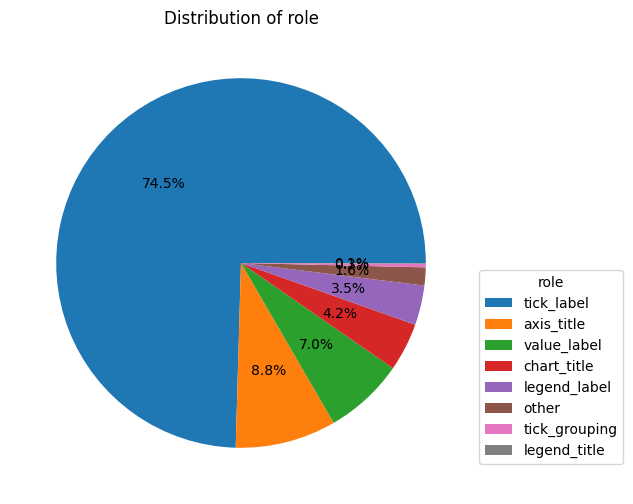

In [63]:
counts = df_chimie_r["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [64]:
df_chimie_r["chart_type"].value_counts()

chart_type
bar      968
dbar     270
line     179
pie      150
dline     20
Name: count, dtype: int64

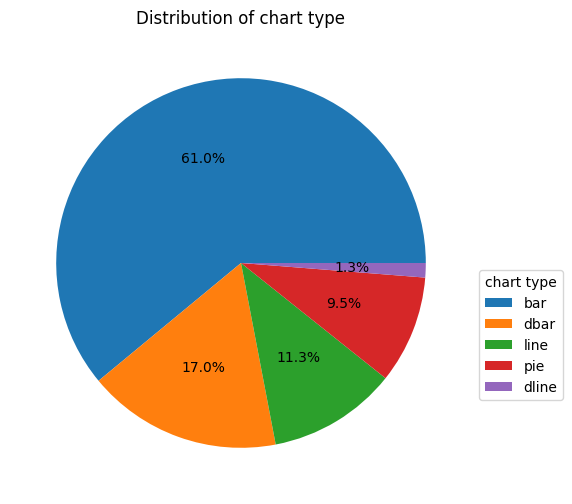

In [65]:
counts = df_chimie_r["chart_type"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [66]:
df_chimie_r.nunique()

text           528
role             8
center_x       598
center_y       504
width          178
height          84
orientation      1
annot_file     115
img            115
chart_type       5
dtype: int64

In [67]:
df_chimie_r[df_chimie_r["role"].notnull()].nunique()

text           528
role             8
center_x       598
center_y       504
width          178
height          84
orientation      1
annot_file     115
img            115
chart_type       5
dtype: int64

In [88]:
random_img_path = df_chimie_r[df_chimie_r["role"].notnull()]["img"].sample(1).values[0]
# random_img_path = "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/split_2/images/PMC6404038___2.jpg"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_chimie_r[df_chimie_r["img"] == random_img_path].iterrows():
    rect = (
        (row["center_x"], row["center_y"]),
        (row["width"], row["height"]),
        row["orientation"],
    )
    points = cv2.boxPoints(rect)  # returns float32
    labeled_polygons.append((points.astype(int), row["role"]))

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    cv2.polylines(img, [points], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (points[0, 0], points[0, 1] + 15),
        font,
        scale,
        color,
        thikness,
    )
cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/CHIME-R/test/images/bar018.bmp


True

In [ ]:
import wandb

api = wandb.Api(api_key="29d0d6a18093ce2fee4a6b00aca4efdc220a8a9d")
run = api.run("/nassimb0u-test/huggingface/runs/tj6nssvd")

#print(run.history())

print(run.logged_artifacts())